<a href="https://colab.research.google.com/github/Pratik00019/Detecting-Finger-Count-using-CNN/blob/main/Detecting_Finger_Count_using_CNN(Convolution_Neural_Network).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.python.framework import ops


%matplotlib inline


In [ ]:
def load_dataset():
    with h5py.File('/content/train_signs.h5', "r") as train_dataset:
        train_set_x_orig = np.array(train_dataset["train_set_x"][:])
        train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    with h5py.File('/content/test_signs.h5', "r") as test_dataset:
        test_set_x_orig = np.array(test_dataset["test_set_x"][:])
        test_set_y_orig = np.array(test_dataset["test_set_y"][:])
        classes = np.array(test_dataset["list_classes"][:])


    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [ ]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()


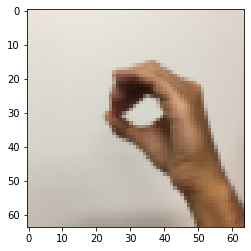

In [ ]:
index = 50
plt.imshow(X_train_orig[index])

In [ ]:
def one_hot_matrix(labels, C):

    C = tf.constant(C, name='C')
    one_hot_matrix = tf.one_hot(indices=labels, depth=C, axis=0)
    sess = tf.Session()
    one_hot = sess.run(one_hot_matrix)
    sess.close()
    return one_hot

In [ ]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = one_hot_matrix(Y_train_orig, 6).T
Y_test = one_hot_matrix(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 1, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 1, 6)


**CREATING PLACEHOLDERS**

We need to create placeholders becuase as we know that Tensorflow works on computational graph and also TensorFlow requires that we create placeholders for the input data that will be fed into the model when running the session.

In [ ]:
def create_placeholders(n_h,n_w,n_c,n_y):
  """
  n_h = height of image
  n_w = width of image
  n_c = channels of image
  n_y = classes

  """
  X=tf.placeholder(tf.float32,shape=[None,n_h,n_w,n_c])
  Y=tf.placeholder(tf.float32,shape=[None,n_y])

  return X,Y


In [ ]:
X, Y = create_placeholders(64, 64, 3, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder_2:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_3:0", shape=(?, 6), dtype=float32)


In [ ]:
def initialize_parameters():
      W1 = tf.get_variable('W1',[4, 4, 3, 8], initializer = tf.truncated_normal_initializer(stddev=0.1))
      W2= tf.get_variable('W2',[2, 2, 8, 16],initializer = tf.truncated_normal_initializer(stddev=0.1))
      
      parameters={"W1":W1,"W2":W2}

      return parameters


We dont have to add bias as tensorflow does it on it's own and also when we apply fully connected layer we don't initialize weights and bias as tensorflow innitalizes on its own 

In [ ]:
def forward_propogation(X,parameters):
  W1=parameters["W1"]
  W2=parameters["W2"]
  
  Z1=tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
  A1=tf.relu(Z1)
  P1=tf.nn.max_pool(A1,ksize = [1,8,8,1],strides = [1,8,8,1],padding ='SAME')

  Z2=tf.nn.conv2d(P1,W2,strides = [1,1,1,1] ,padding='SAME')
  A2=tf.relu(Z2)
  P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')

  P2 = tf.contrib.layers.flatten(P2)
  
  Z3 = tf.contrib.layers.fully_connected(P2, 6, activation_fn=None)
  return Z3



In [ ]:
def compute_cost(Z3, Y):

    cost = tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y)
    cost = tf.reduce_mean(cost)
    
    return cost

In [ ]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                         
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    parameters = initialize_parameters()
    
    Z3 = forward_propagation(X, parameters)
  
    cost = compute_cost(Z3, Y)

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
          
                ### START CODE HERE ### (1 line)
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                minibatch_cost += temp_cost / num_minibatches
                
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

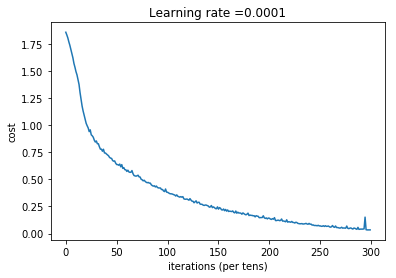